In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from best_subset import *
from UBIC import *

from sklearn import feature_selection as fs
import shap

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

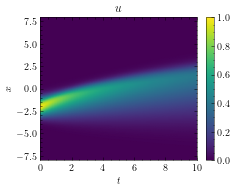

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    ufig.savefig("../Figures/burgers.png", dpi=300)
    plt.show()

#### Add noise

In [4]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


#### Use the precomputed denoised variable given by the K-SVD

In [5]:
denoised = True
if denoised: un = np.load("./denoised_files/burgers_dictlearn_denoised30_components32_8x8.npy")

#### Applying best-subset regression on the weak formulation

In [6]:
poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference; differentiation_kwargs = {}
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )

X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)
# y_pre = y_pre - y_pre.mean(axis=0)
fns

['x0',
 'x0x0',
 'x0_{x}',
 'x0_{xx}',
 'x0x0_{x}',
 'x0x0x0_{x}',
 'x0x0_{xx}',
 'x0x0x0_{xx}']

In [7]:
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]

### F-test

In [8]:
# Is u_{x} significant?
alpha = 0.05
model0 = sm.OLS(y_pre, X_pre[:, best_subsets[1]], hasconst=False).fit()
model1 = sm.OLS(y_pre, X_pre[:, best_subsets[2]], hasconst=False).fit()
f_test_res = sm.stats.anova_lm(model0, model1).iloc[-1]
f_statistic, p_value = f_test_res['F'], f_test_res['Pr(>F)']
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")
if p_value < alpha:
    print("The additional feature is significant in predicting the target variable.")
else:
    print("The additional feature is not significant in predicting the target variable.")

F-statistic: 11.349618489137109
P-value: 0.0007574864881534299
The additional feature is significant in predicting the target variable.


#### Mutual information

In [9]:
mutual_info = fs.mutual_info_regression(X_pre, y_pre)
sorting_indices = np.argsort(mutual_info)[::-1]
mutual_info[sorting_indices], np.array(fns)[sorting_indices]

(array([0.97556593, 0.94677428, 0.87256523, 0.6650905 , 0.6494026 ,
        0.62173837, 0.48995862, 0.43541525]),
 array(['x0x0x0_{x}', 'x0x0_{x}', 'x0_{x}', 'x0x0', 'x0', 'x0x0x0_{xx}',
        'x0x0_{xx}', 'x0_{xx}'], dtype='<U11'))

In [10]:
shaps = np.array([0.00107794, 0.00099889, 0.00715736, 0.00148111, 0.00082081, 0.00439339, 0.00050938, 0.00097005], dtype=np.float32)
fns = ['$u$','$u^{2}$','$u_{x}$','$u_{xx}$','$uu_{x}$','$u^{2}u_{x}$','$uu_{xx}$','$u^{2}u_{xx}$']

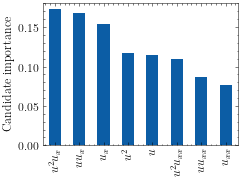

In [11]:
with plt.style.context('science'):
    mi = pd.Series(mutual_info)
    mi = mi/mi.sum()
    mi.index = fns
    mi.sort_values(ascending=False, inplace=True)
    # (?) Mutual information for each candidate
    # plt.title('Ranking by mutual information', fontsize=12)
    mi.plot.bar(fontsize=12)
    plt.ylabel("Candidate importance", fontsize=12)
    plt.savefig("mutual_info.pdf")
    plt.show()

In [12]:
# np.load("X_weak_burgers.npy")
# np.load("y_weak_burgers.npy")
# np.load("best_subsets_burgers.npy", allow_pickle=True)

In [13]:
linear_model = SkLinearRegression(fit_intercept=False).fit(X_pre, y_pre)
explainer = shap.Explainer(linear_model.predict, X_pre)
shap_values = explainer(X_pre)

Exact explainer: 10001it [00:33, 226.01it/s]                                                                                                    


In [14]:
candidate_importance = np.abs(shap_values.values).mean(axis=0)
candidate_importance = candidate_importance/candidate_importance.sum()

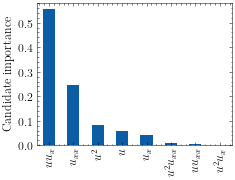

In [15]:
with plt.style.context('science'):
    mi = pd.Series(candidate_importance)
    mi = mi/mi.sum()
    mi.index = fns
    mi.sort_values(ascending=False, inplace=True)
    # (?) Mutual information for each candidate
    # plt.title('Ranking by SHAP value', fontsize=12)
    mi.plot.bar(fontsize=12)
    plt.ylabel("Candidate importance", fontsize=12)
    plt.savefig("shap.pdf")
    plt.show()

In [44]:
f_scores, _ = fs.f_regression(X_pre, y_pre)
sorting_indices = np.argsort(f_scores)[::-1]
f_scores[sorting_indices], np.array(fns)[sorting_indices]

(array([39597.08633088, 33249.0402039 , 26044.00310333,   644.04920612,
          605.75237157,   543.5305861 ,    39.8190605 ,    39.77767518]),
 array(['$uu_{x}$', '$u_{x}$', '$u^{2}u_{x}$', '$u^{2}$', '$u_{xx}$',
        '$u$', '$u^{2}u_{xx}$', '$uu_{xx}$'], dtype='<U13'))

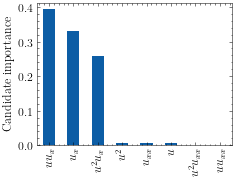

In [45]:
with plt.style.context('science'):
    mi = pd.Series(f_scores)
    mi = mi/mi.sum()
    mi.index = fns
    mi.sort_values(ascending=False, inplace=True)
    # (?) Mutual information for each candidate
    # plt.title('Ranking by mutual information', fontsize=12)
    mi.plot.bar(fontsize=12)
    plt.ylabel("Candidate importance", fontsize=12)
    plt.savefig("f_regression.pdf")
    plt.show()

In [60]:
r_scores = np.array([SkLinearRegression(fit_intercept=False).fit(X_pre[:, i:i+1], y_pre).score(X_pre[:, i:i+1], y_pre) for i in range(X_pre.shape[-1])])
sorting_indices = np.argsort(r_scores)[::-1]
r_scores[sorting_indices], np.array(fns)[sorting_indices]

(array([0.79839749, 0.7687904 , 0.7226005 , 0.05708643, 0.04711015,
        0.03377256, 0.00378066, 0.00329149]),
 array(['$uu_{x}$', '$u_{x}$', '$u^{2}u_{x}$', '$u_{xx}$', '$u^{2}$',
        '$u$', '$u^{2}u_{xx}$', '$uu_{xx}$'], dtype='<U13'))

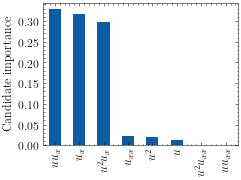

In [61]:
with plt.style.context('science'):
    mi = pd.Series(r_scores)
    mi = mi/mi.sum()
    mi.index = fns
    mi.sort_values(ascending=False, inplace=True)
    # (?) Mutual information for each candidate
    # plt.title('Ranking by mutual information', fontsize=12)
    mi.plot.bar(fontsize=12)
    plt.ylabel("Candidate importance", fontsize=12)
    plt.savefig("r_scores.pdf")
    plt.show()

In [16]:
# y_pre = y_pre-y_pre.mean(axis=0)

In [17]:
# tau = 3
# verbose = True
# scale = np.log(len(y_pre))
# # scale = 1 <- generalized UBIC
# per = 75

# post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
# predictions = X_pre@post_means

# b_bics = np.array(b_bics)
# max_complexity = len(b_bics)
# complexities = np.arange(max_complexity)+1
# d_complexities = complexities[decreasing_values_indices(b_bics)]
# d_bics = b_bics[decreasing_values_indices(b_bics)]
# slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
# thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# # thres = 0.02
# print("threshold:", thres)

# lower_bounds = []
# for k, efi in enumerate(best_subsets):
#     assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
#     com = len(efi)
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*com
#     lower_bounds.append(lower_bound)

# last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
# print("max_lam:", last_lam)
# delta = last_lam/tau
# now_lam = last_lam-delta
# last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
# last_bc = np.argmin(last_ubic)
# while now_lam >= 0:
#     now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
#     now_bc = np.argmin(now_ubic)
    
#     diff_com = now_bc-last_bc
#     diff_bic = b_bics[now_bc]-b_bics[last_bc]
#     imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
#     if verbose:
#         print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
#               np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break
    
#     last_lam = now_lam
#     now_lam = round(last_lam-delta, 8)
#     last_ubic = now_ubic
#     last_bc = now_bc

# best_bc = last_bc
# if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
#     best_bc = best_bc - 1
    
# last_lam = round(last_lam, 10)
# last_lam, last_ubic, last_bc, best_bc